In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


from scipy.sparse import lil_matrix
import scipy
from collections import defaultdict
import operator
import math
%matplotlib inline

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
people = pd.read_csv('10k-people-raw.csv', sep=';')

In [4]:
vip = []
print('Name\t\t\t', 'Index')
for index, name in enumerate(people['Name']):
    if name == 'Michael Schumacher':
        vip.append((index, 'Michael Schumacher'))
        print('Michael Schumacher:\t', index)
    if name == 'Albert Einstein':
        vip.append((index, 'Albert Einstein'))
        print('Albert Einstein:\t', index)
    if name == 'Michael Jackson':
        vip.append((index, 'Michael Jackson'))
        print('Michael Jackson:\t', index)

Name			 Index
Michael Schumacher:	 3
Albert Einstein:	 215
Michael Jackson:	 1951


In [5]:
print(vip)

[(3, 'Michael Schumacher'), (215, 'Albert Einstein'), (1951, 'Michael Jackson')]


In [6]:
print(people['text'][3][:600])
print()
print(people['text'][215][:600])
print()
print(people['text'][1951][:600])

Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Michael Schumacher (* 3. Januar 1969 in Hürth-Hermülheim, Nordrhein-Westfalen) ist ein ehemaliger deutscher Automobilrennfahrer. Schumacher startete von 1991 bis 2006 sowie von 2010 bis 2012 zu insgesamt 307 Großen Preisen der Formel-1-Weltmeisterschaft. Mit sieben Weltmeistertiteln, 91 Siegen, 68 Pole-Positions und 77 schnellsten Rennrunden ist er der erfolgreichste Pilot der Formel-1-Geschichte. Darüber hinaus stand er mit 155 Platzierungen unter den Top drei am häufigsten auf dem Siegerpodest. Nachdem Schumacher 1990 und 1991 in der Spo

Albert Einstein (* 14. März 1879 in Ulm; † 18. April 1955 in Princeton, New Jersey) war ein theoretischer Physiker. Seine Forschungen zur Struktur von Materie, Raum und Zeit sowie dem Wesen der Gravitation veränderten maßgeblich das physikalische Weltbild. Er gilt daher als einer der bedeutendsten Physiker aller Zeiten. Einsteins Hauptwerk, die Relativitätstheorie, machte ihn weltberühmt. Im Jah

In [7]:
import nltk
stem = nltk.stem.snowball.SnowballStemmer('german')

In [8]:
text = people['text'][1951][:600]
stemmed_text_example = []
stemmed_text_example.append(' '.join([stem.stem(word.lower()) for word in nltk.word_tokenize(str(text.encode('utf8')))
                              if word.isalpha() ]))

In [9]:
stemmed_text_example

['joseph jackson august in gary indiana juni in los angel kaliforni war ein komponist und entertain aufgrund sein erfolg wird er als of bezeichnet jackson gilt mit weltweit etwa bis million verkauft laut der rekord als erfolgreich entertain all zeit and quell geb sogar bis zu million abgesetzt platt an postum verkauft sich innerhalb ein jahr nach sein tod weit million sein alb jackson wurd bereit als kind teil der in d']

####  Vielleicht wollen Sie das Pre-Processing etwas verbessern um Umlaut  (ä --> ae, ... ), Wort-Verbindungen (US-amerikanisch, Guinness-Buch, ... ) etc.  zu "retten"

In [68]:
#from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python 
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [10]:
stopwords = set()
with open("GermanST.txt", "r") as f:
    stopwords = set([word.lower().strip() for word in f.readlines()])

stemmed_stopwords = [stem.stem(word) for word in stopwords]

In [11]:
class Preprocessor:
    def __init__(self, texts):
        self.word_dict = dict()
        self.word_stopped_dict = dict()
        self.stemmed_dict = dict()
        self.stemmed_stoppped_dict = dict()

        self.all_words = []
        self.words_stopped = []
        self.words_stemmed = []
        self.words_stemmed_stopped = []

        i = 0
        k = 0
        j = 0
        l = 0

        for doc_id, text in enumerate(texts):
            self.all_words.append([])
            self.words_stopped.append([])
            self.words_stemmed.append([])
            self.words_stemmed_stopped.append([])

            for word in nltk.word_tokenize(str(text.encode('utf8'))):
                if not word.isalpha(): continue
                word = word.replace(u"ö", "oe").replace(u"ü", "ue").replace(u"ä", "ae").lower()
                if word not in self.word_dict:
                    self.word_dict[word] = i
                    i += 1
                    if word not in stopwords:
                        self.word_stopped_dict[word] = j
                        j += 1

                stemmed = stem.stem(word)
                if stemmed not in self.stemmed_dict:
                    self.stemmed_dict[stemmed] = k
                    k += 1
                    if stemmed not in stemmed_stopwords:
                        self.stemmed_stoppped_dict[stemmed] = l
                        l += 1

                self.all_words[-1].append(word)
                if word not in stopwords:
                    self.words_stopped[-1].append(word)

                self.words_stemmed[-1].append(stemmed)
                if stemmed not in stemmed_stopwords:
                    self.words_stemmed_stopped[-1].append(stemmed)
                

In [12]:
preprocessor = Preprocessor(people['text'])

In [13]:
print(len(preprocessor.word_dict))
print(len(preprocessor.word_stopped_dict))
print(len(preprocessor.stemmed_dict))
print(len(preprocessor.stemmed_stoppped_dict))

298054
297555
222679
222345


In [136]:
def cos_dist(a: np.ndarray, b: np.ndarray):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def scalar(a: np.ndarray, b: np.ndarray):
    return np.dot(a, b)

def compareBest10(a, b):
    for i in range(len(a)):
        a_set = set([s[0] for s in a[i]])
        b_set = set([s[0] for s in b[i]])
        
        removed = a_set - b_set
        added = b_set - a_set
        
        print(color.BOLD + vip[i][1] + color.END)
        
        print("only in a")
        for idx in removed:
            print(people['Name'][idx])
        print()
        print("only in b")
        for idx in added:
            print(people['Name'][idx])
        print()
    
def get_word_count(sims):
    for sim in sims:
        idx = sim[0]
        print(people['Name'][idx])
        print(len(people['text'][idx]))
        print()
        
def print_all_10_best(func):
    best = []
    for v in vip:
        print(color.BOLD + v[1] + color.END)
        b = func(v[0])
        best.append(b)
        print()
    return best

In [52]:
class Document:
    def __init__(self, doc):
        self.doc = doc

    def bow_similarity(self, id: int, use_cos_dist=False):
        sims = []

        for i in range(self.doc.shape[0]):
            if i == id: continue
            a = self.doc[id, :].toarray().flatten()
            b = self.doc[i, :].toarray().flatten()
            if use_cos_dist:
                sims.append((i, cos_dist(a, b)))
            else:
                sims.append((i, scalar(a, b)))

        return list(sorted(sims, key=lambda sim: sim[1], reverse=True))

    def print_best_10(self, id, use_cos_dist=False, with_text=True):
        best10 = []
        for sim in self.bow_similarity(id, use_cos_dist=use_cos_dist)[:10]:
            idx = sim[0]
            print(people['Name'][idx])
            if with_text:
                print(people['text'][idx][:400])
            print(f"similarity: {sim[1]}")
            print()
            best10.append(sim)
            
        return best10

In [ ]:
class BagOfWord(Document):
    def __init__(self, word_array, word_dict):
        bag_of_words = lil_matrix((len(word_array), len(word_dict)))
        print(bag_of_words.shape)

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                bag_of_words[i, idx] = 1

        super().__init__(bag_of_words)

## Some stats

In [46]:
lengs = [len(ppl) for ppl in people["text"]]
print(f"max {max(lengs)}")
print(f"min {min(lengs)}")

max 104847
min 620


# 1) Zipf law

In [17]:
word_dict = defaultdict(int)
word_count = 0
word_index = {}

i = 0
for text in people['text']:
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        word_dict[w] += 1
        word_count += 1
        if w not in word_index:
            word_index[w] = i
            i += 1

In [18]:
rel_dict = defaultdict(float)
rank = []

for key, value in sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True):
    rel_dict[key] = value / word_count
    rank.append(rel_dict[key])

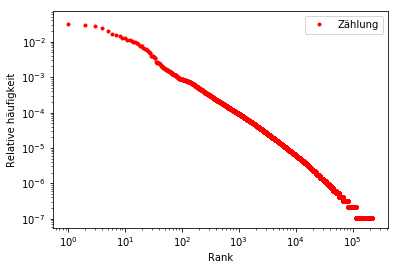

In [19]:
fig, ax = plt.subplots()
plt_rank = plt.plot(np.arange(len(rank)), rank, 'r.', label="Zählung")
plt.xlabel('Rank')
plt.ylabel('Relative häufigkeit')
plt.legend(["Zählung", "Zipf law"])
ax.set_yscale("log", nonposy='clip')
ax.set_xscale("log")

# 2) Bag of Words

In [54]:
class BagOfWord(Document):
    def __init__(self, word_array, word_dict):
        bag_of_words = lil_matrix((len(word_array), len(word_dict)))
        print(bag_of_words.shape)

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                bag_of_words[i, idx] = 1

        super().__init__(bag_of_words)

In [55]:
bow = BagOfWord(preprocessor.all_words, preprocessor.word_dict)

(10000, 298054)


In [111]:
best_2 = print_all_10_best(lambda vip_id: bow.print_best_10(vip_id, use_cos_dist=False))

Michael Schumacher
Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 691.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 652.0

Fernando Alonso
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Fernando Alonso Díaz (* 29. 

Marlon Brando
Marlon Brando, Jr. (* 3. April 1924 in Omaha, Nebraska; † 1. Juli 2004 in Los Angeles, Kalifornien) war ein amerikanischer Schauspieler. Er gilt als einer der bedeutendsten Charakterdarsteller der Filmgeschichte des 20. Jahrhunderts. Mit seinen Rollen in den Filmen Endstation Sehnsucht (1951) und Die Faust im Nacken (1954) verschaffte er der Schauspieltechnik des Method Acting weltweit Beachtung. 
similarity: 280.0

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 273.0

Mahatma Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; gen

In [63]:
for i, b in enumerate(best_2):
    print(vip[i][1])
    get_word_count(b)

Michael Schumacher
Wallenstein
104847

Theobald von Bethmann Hollweg
86072

Fernando Alonso
42546

Benjamin Franklin
82190

Florence Nightingale
81552

Herbert C. Hoover
79076

Herbert Hoover
79076

George Washington
63064

Lewis Hamilton
36099

Marlon Brando
75366

Albert Einstein
Benjamin Franklin
82190

Theobald von Bethmann Hollweg
86072

Max Liebermann
62634

Florence Nightingale
81552

Mahatma Gandhi
70125

Mohandas Karamchand Gandhi
70125

Max Planck
38364

Wallenstein
104847

Herbert C. Hoover
79076

Herbert Hoover
79076

Michael Jackson
Marlon Brando
75366

Wallenstein
104847

Mahatma Gandhi
70125

Mohandas Karamchand Gandhi
70125

Benjamin Franklin
82190

Michael Schumacher
80566

Maria I. (England)
69400

George Washington
63064

Florence Nightingale
81552

Grigori Rasputin
62367



## Diskussion
Die Vergleiche sind nicht sehr ausagekräftig. Fernando Alonso und Lewis Hamilton sind beised Formel-1 Fahrer die restlichen Personen haben nicht viel gemeinsam mit Schumacher.


Wallenstein ist das Document mit den meisten Wörtern, dh. die Warscheinlichkeit das wörte übereinstimme mit Wallenstein und den vip personnen ist hoch deswegen kommt Wallenstein bei allen drei vip personen vor.

Wir sehen allgemein das lange Texte bevorzugt werden.

# 3) Bag of Words without stop words

In [94]:
bow_stopped = BagOfWord(preprocessor.words_stopped, preprocessor.word_stopped_dict)

(10000, 297555)


In [101]:
best_3 = print_all_10_best(lambda vip_id: bow_stopped.print_best_10(vip_id, use_cos_dist=False))

Michael Schumacher
Fernando Alonso
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Fernando Alonso Díaz (* 29. Juli 1981 in Oviedo, Asturien) ist ein spanischer Automobilrennfahrer. Er startet seit 2001 in der Formel 1 und gewann dort 2005 und 2006 auf Renault die Weltmeisterschaft. Von 2010 bis 2014 startete Alonso für den italienischen Traditionsrennstall Ferrari, mit dem er 2010, 2012 und 2013 Vizeweltmeister wurde. 2007 
similarity: 446.0

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 436.0

Lewis Hamilton
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Lewis Carl Davidson Hamilton, MBE (* 7. Jan

Marlon Brando
Marlon Brando, Jr. (* 3. April 1924 in Omaha, Nebraska; † 1. Juli 2004 in Los Angeles, Kalifornien) war ein amerikanischer Schauspieler. Er gilt als einer der bedeutendsten Charakterdarsteller der Filmgeschichte des 20. Jahrhunderts. Mit seinen Rollen in den Filmen Endstation Sehnsucht (1951) und Die Faust im Nacken (1954) verschaffte er der Schauspieltechnik des Method Acting weltweit Beachtung. 
similarity: 140.0

Mahatma Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; genannt Mahatma Gandhi; * 2. Oktober 1869 in Porbandar, Gujarat; † 30. Januar 1948 in Neu-Delhi, Delhi) war ein indischer Rechtsanwalt, Widerstandskämpfer, Revolutionär, Publizist, Morallehrer, Asket und Pazifist. Zu Beginn des 20. Jahrhunderts setzte sich Gandhi in Südafrika gegen d
similarity: 134.0

Mohandas Karamchand Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamch

In [118]:
compareBest10(best_2, best_3)

Michael Schumacher
only in a
George Washington

only in b
Sebastian Vettel

Albert Einstein
only in a
Wallenstein

only in b
Otto Hahn

Michael Jackson
only in a
Grigori Rasputin
Florence Nightingale

only in b
Ulrike Meinhof
Madonna (Künstlerin)



## Diskussion
Durch das entfernen der stopword hat sich Fernando Alonso an die Spize verschoben bei Schumacher was schonmal eine Verbesserung ist.

Eine weitere Verbesserung haben wir mit dem dazukommen von
Sebastian Vettel bei Schumacher
Otto Hahn bei Einstein
Madonna  bei Jackson

Wallenstein ist jetzt bei Albert Einstein nicht mehr in den Top 10, da sieht man gut das die stopwords removal eine Verbesserung erbracht hat.

# 4a) Term frequency without stop words

In [119]:
class UnaryCounts(Document):
    def __init__(self, word_array, word_dict):
        tfidf = lil_matrix((len(word_array), len(word_dict)))
        print(tfidf.shape)

        word_counts = []

        for i in range(len(word_array)):
            word_counts.append(defaultdict(int))
            for word in word_array[i]:
                word_counts[i][word] += 1

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                tfidf[i, idx] = word_counts[i][word]

        super().__init__(tfidf)

In [120]:
unaryCounts = UnaryCounts(preprocessor.words_stopped, preprocessor.word_stopped_dict)

(10000, 297555)


In [121]:
best_4a = print_all_10_best(lambda vip_id: unaryCounts.print_best_10(vip_id, use_cos_dist=False))

Michael Schumacher
Fernando Alonso
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Fernando Alonso Díaz (* 29. Juli 1981 in Oviedo, Asturien) ist ein spanischer Automobilrennfahrer. Er startet seit 2001 in der Formel 1 und gewann dort 2005 und 2006 auf Renault die Weltmeisterschaft. Von 2010 bis 2014 startete Alonso für den italienischen Traditionsrennstall Ferrari, mit dem er 2010, 2012 und 2013 Vizeweltmeister wurde. 2007 
similarity: 36559.0

Lewis Hamilton
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Lewis Carl Davidson Hamilton, MBE (* 7. Januar 1985 in Stevenage, Hertfordshire, England) ist ein britischer Automobilrennfahrer. Hamilton wurde 1998 ins Förderprogramm des Formel-1-Rennstalls McLaren aufgenommen. Er gewann 2005 die Formel-3-Euroserie und 2006 die GP2-Serie. Seit 2007 startet er in der Formel 1. Von 2007 bis 2012 ging Hamilton
similarity: 28887.0

Sebastian Vettel
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Sebastian Vettel (* 3. Juli 1987 i

Janet Jackson
Janet Damita Jo Jackson (* 16. Mai 1966 in Gary, Indiana) ist eine US-amerikanische Sängerin, Tänzerin und Schauspielerin. Sie ist das jüngste Mitglied der Musikerfamilie Jackson. Ihre fünf älteren Brüder wurden als die Jackson Five bekannt, ihr Bruder Michael Jackson war einer der erfolgreichsten Pop-Musiker. Mit mehr als 160 Millionen verkauften Tonträgern zählt Janet Jackson ihrerseits zu den e
similarity: 6559.0

Thomas Jonathan Jackson
Thomas Jonathan Jackson (genannt „Stonewall“; * 21. Januar 1824 in Clarksburg, Virginia (heute West Virginia); † 10. Mai 1863 in Guinea Station, Spotsylvania County, Virginia) war Major des US-Heeres, Lehrer am Virginia Military Institute (VMI) in Lexington, Virginia, und General im Heer der Konföderierten Staaten von Amerika im Amerikanischen Bürgerkrieg. Bekannt ist er vor allem durch den erfolg
similarity: 2737.0

Peter Jackson
Sir Peter Jackson KNZM ONZ (* 31. Oktober 1961 in Pukerua Bay, Neuseeland) ist ein neuseeländischer Filmre

In [122]:
compareBest10(best_3, best_4a)

Michael Schumacher
only in a
Wallenstein
Theobald von Bethmann Hollweg
Benjamin Franklin
Florence Nightingale
Marlon Brando
Herbert C. Hoover
Herbert Hoover

only in b
Jenson Button
Rubens Barrichello
Juan Pablo Montoya
Alain Prost
Ralf Schumacher
Nico Rosberg
Kimi Räikkönen

Albert Einstein
only in a
Florence Nightingale
Herbert C. Hoover
Herbert Hoover
Mahatma Gandhi
Mohandas Karamchand Gandhi

only in b
Wilhelm Solf
James M. Gavin
Wilhelm Canaris
Albert von Sachsen-Coburg und Gotha
Alma Mahler-Werfel

Michael Jackson
only in a
Wallenstein
Benjamin Franklin
Michael Schumacher
Madonna (Künstlerin)
Maria I. (England)
Mahatma Gandhi
Mohandas Karamchand Gandhi
George Washington
Ulrike Meinhof

only in b
Andrew Jackson
Janet Jackson
Mick Foley
James M. Gavin
Mariah Carey
Alvin Ira Malnik
Peter Jackson
George Michael
Thomas Jonathan Jackson



## Diskussion
Counts alleine bring uns schon eine grosse Verbesserung.
Top 10 von Schumacher besteht jetzt nur noch auch Formel-1-Fahrer da in diesen Texten warscheinlich viele ähnliche wörte wie z.b rennen oder Formel-1 vorkommen.

Bei Albert Einstein kommen viele Persönlichkeiten aus dem 2. Weltkrieg hinzu. Weltkrieg kommt 8 mal auf der Wikipedia seite von Albert Einstein an verschiedenen Orsten vor.

Da auf der Wikipedia seite von Michael Jackson das Wort Jackson 460 mal vorkommt wird diesses hoch gewichtet. Somit werden kommen viele Persönlichkeiten mit dem namen Jackson dazu.

Wallenstein ist jetzt aus allen 3 Top 10 verschwunden. Da zwar einige gemeinsame Wörte zu den 3 Personen (da längstes Dokumen) hat sie aber nicht sehr häufig vorkommen.

# 4b) Term frequency without stop words and with stemming

In [123]:
unaryCounts_stemmed = UnaryCounts(preprocessor.words_stemmed_stopped, preprocessor.stemmed_stoppped_dict)

(10000, 222345)


In [124]:
best_4b = print_all_10_best(lambda vip_id: unaryCounts_stemmed.print_best_10(vip_id, use_cos_dist=False))

Michael Schumacher
Fernando Alonso
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Fernando Alonso Díaz (* 29. Juli 1981 in Oviedo, Asturien) ist ein spanischer Automobilrennfahrer. Er startet seit 2001 in der Formel 1 und gewann dort 2005 und 2006 auf Renault die Weltmeisterschaft. Von 2010 bis 2014 startete Alonso für den italienischen Traditionsrennstall Ferrari, mit dem er 2010, 2012 und 2013 Vizeweltmeister wurde. 2007 
similarity: 42493.0

Lewis Hamilton
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Lewis Carl Davidson Hamilton, MBE (* 7. Januar 1985 in Stevenage, Hertfordshire, England) ist ein britischer Automobilrennfahrer. Hamilton wurde 1998 ins Förderprogramm des Formel-1-Rennstalls McLaren aufgenommen. Er gewann 2005 die Formel-3-Euroserie und 2006 die GP2-Serie. Seit 2007 startet er in der Formel 1. Von 2007 bis 2012 ging Hamilton
similarity: 33378.0

Sebastian Vettel
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Sebastian Vettel (* 3. Juli 1987 i

Janet Jackson
Janet Damita Jo Jackson (* 16. Mai 1966 in Gary, Indiana) ist eine US-amerikanische Sängerin, Tänzerin und Schauspielerin. Sie ist das jüngste Mitglied der Musikerfamilie Jackson. Ihre fünf älteren Brüder wurden als die Jackson Five bekannt, ihr Bruder Michael Jackson war einer der erfolgreichsten Pop-Musiker. Mit mehr als 160 Millionen verkauften Tonträgern zählt Janet Jackson ihrerseits zu den e
similarity: 8341.0

Thomas Jonathan Jackson
Thomas Jonathan Jackson (genannt „Stonewall“; * 21. Januar 1824 in Clarksburg, Virginia (heute West Virginia); † 10. Mai 1863 in Guinea Station, Spotsylvania County, Virginia) war Major des US-Heeres, Lehrer am Virginia Military Institute (VMI) in Lexington, Virginia, und General im Heer der Konföderierten Staaten von Amerika im Amerikanischen Bürgerkrieg. Bekannt ist er vor allem durch den erfolg
similarity: 3871.0

Peter Jackson
Sir Peter Jackson KNZM ONZ (* 31. Oktober 1961 in Pukerua Bay, Neuseeland) ist ein neuseeländischer Filmre

In [146]:
compareBest10(best_4a, best_4b)

Michael Schumacher
only in a

only in b

Albert Einstein
only in a
Albert von Sachsen-Coburg und Gotha
Wilhelm Canaris

only in b
August Bebel
Johannes Haller

Michael Jackson
only in a
Mick Foley

only in b
Bo Jackson



## Diskussion
Bei Schumacher hat sich nicht viel verändert Nico Rosberg und Jenson Button haben die Position gewächselt.

Bei Einstein haben wir einen deutschen Prinz und einen deutschen Admiral verloren. Und einen deutscher Politiker und einen deutscher Historiker hinzubekommen. Da Einstein ein Kapitel Politisches Engagement und eine wichtige Historische person ist mach die änderung sinn.

Michal Jackon hat noch eine Persönlichkeit mit dem name Jackson dazubekommen.

# 4c) Term frequency, stopped, stemmed and Cosine Similarity

In [147]:
best_4c = print_all_10_best(lambda vip_id: unaryCounts_stemmed.print_best_10(vip_id, use_cos_dist=True))

Michael Schumacher
Ralf Schumacher
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Vorlage:Infobox DTM-Fahrer/Wartung/Alte Parameter Ralf Schumacher (* 30. Juni 1975 in Hürth-Hermülheim) ist ein ehemaliger deutscher Automobilrennfahrer. Er startete zwischen 1997 und 2007 zu 180 Grand-Prix-Rennen in der Formel 1 und gewann sechs davon. Von 2008 bis 2012 fuhr Schumacher in der DTM für Mercedes-Benz. 1996 wurde er Meister der F
similarity: 0.8194610823630551

Rubens Barrichello
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Rubens Gonçalves Barrichello [Aussprache: ˈhubẽjs bahiˈkɛlu] (* 23. Mai 1972 in São Paulo) ist ein brasilianischer Automobilrennfahrer. Barrichello startete zwischen 1993 und 2011 bei insgesamt 323 Formel-1-Rennen und ist damit alleiniger Rekordhalter an Grand-Prix-Starts. In den Jahren 2002 und 2004 wurde er jeweils auf Ferrari Vizeweltmeiste
similarity: 0.5437097244453025

Fritz Schumacher
Fritz Schumacher (* 4. November 1869 in Bremen; †  5. November 

Janet Jackson
Janet Damita Jo Jackson (* 16. Mai 1966 in Gary, Indiana) ist eine US-amerikanische Sängerin, Tänzerin und Schauspielerin. Sie ist das jüngste Mitglied der Musikerfamilie Jackson. Ihre fünf älteren Brüder wurden als die Jackson Five bekannt, ihr Bruder Michael Jackson war einer der erfolgreichsten Pop-Musiker. Mit mehr als 160 Millionen verkauften Tonträgern zählt Janet Jackson ihrerseits zu den e
similarity: 0.6193465252106232

Thomas Jonathan Jackson
Thomas Jonathan Jackson (genannt „Stonewall“; * 21. Januar 1824 in Clarksburg, Virginia (heute West Virginia); † 10. Mai 1863 in Guinea Station, Spotsylvania County, Virginia) war Major des US-Heeres, Lehrer am Virginia Military Institute (VMI) in Lexington, Virginia, und General im Heer der Konföderierten Staaten von Amerika im Amerikanischen Bürgerkrieg. Bekannt ist er vor allem durch den erfolg
similarity: 0.5980985219122907

Andrew Jackson
Andrew Jackson (* 15. März 1767 in den Waxhaws; † 8. Juni 1845 nahe Nashville, Te

In [148]:
compareBest10(best_4b, best_4c)

Michael Schumacher
only in a
Jenson Button
Juan Pablo Montoya
Alain Prost
Sebastian Vettel
Lewis Hamilton
Nico Rosberg

only in b
Fritz Schumacher
Jacques Villeneuve
Marc Márquez
Kurt Schumacher
Ryan Hunter-Reay
Takuma Satō

Albert Einstein
only in a
Theobald von Bethmann Hollweg
Wilhelm Solf
Benjamin Franklin
James M. Gavin
August Bebel
Max Planck
Max Liebermann
Johannes Haller
Otto Hahn
Alma Mahler-Werfel

only in b
Albert Brooks
Satyendra Nath Bose
Heinrich Mann
John Archibald Wheeler
Kurt Gödel
Max Born
Mileva Marić
Leó Szilárd
Max von Laue
Hermann Weyl

Michael Jackson
only in a
James M. Gavin
Mariah Carey
Alvin Ira Malnik
Marlon Brando

only in b
Samuel L. Jackson
George Jackson
Alan Jackson
50 cent



## Diskussion
Mit der Cosine Similarity spielen jetzt auch nicht gleiche Wörte eine Rolle. Das führt dazu das jetzt Schumachers Bruder sehr hoch eingestuft wird.

Fritz Schumacher hat da er Architect ist und nicht rennfahre auch viele Worte welche nicht im Michael Schumacher text vorkommen.

Albert Brooks aka Albert Lawrence Einstein teilt den gleichen Namen mit Albert Einstein und hat einen kurzen Wikipedia eintrag dies verhilft in in die Top 10

Samuel L. Jackson ergatters sich auch einen Platz bei Michael Jackson dank seinem kurzem Wikipedia text und sein Interesse der Musik in seiner Kindheit.

# 5) TF-IDF

In [149]:
class TfIdf(Document):
    def __init__(self, word_array, word_dict):
        num_docs = people.shape[0]
        idf_dict = defaultdict(int)

        tfidf = lil_matrix((len(word_array), len(word_dict)))
        print(tfidf.shape)
        
        word_counts = []

        for i in range(len(word_array)):
            word_counts.append(defaultdict(int))
            ws = set()
            for word in word_array[i]:
                word_counts[-1][word] += 1
                #word_count[word] += 1
                if word not in ws:
                    ws.add(word)
                    idf_dict[word] += 1

            #for w in ws:
            #    idf_dict[w] += 1

        for i in range(len(word_array)):
            for word in word_array[i]:
                idx = word_dict[word]
                tfidf[i, idx] = word_counts[i][word] * (1 + math.log(num_docs / idf_dict[word]))

        super().__init__(tfidf)

In [150]:
tfidf = TfIdf(preprocessor.words_stemmed_stopped, preprocessor.stemmed_stoppped_dict)

(10000, 222345)


In [151]:
best_5 = print_all_10_best(lambda vip_id: tfidf.print_best_10(vip_id, use_cos_dist=True))

Michael Schumacher
Ralf Schumacher
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Vorlage:Infobox DTM-Fahrer/Wartung/Alte Parameter Ralf Schumacher (* 30. Juni 1975 in Hürth-Hermülheim) ist ein ehemaliger deutscher Automobilrennfahrer. Er startete zwischen 1997 und 2007 zu 180 Grand-Prix-Rennen in der Formel 1 und gewann sechs davon. Von 2008 bis 2012 fuhr Schumacher in der DTM für Mercedes-Benz. 1996 wurde er Meister der F
similarity: 0.8140009967057464

Fritz Schumacher
Fritz Schumacher (* 4. November 1869 in Bremen; †  5. November 1947 in Hamburg; vollständiger Name: Friedrich Wilhelm Schumacher) war ein deutscher Architekt, Stadtplaner, Baubeamter und Hochschullehrer, der viele Jahre als Oberbaudirektor in Hamburg wirkte. Er war Mitbegründer des Deutschen Werkbundes und Förderer der neuzeitlichen Backstein-Bauweise in Norddeutschland.    Jugend und Ausbildung F
similarity: 0.6337598611292564

Kurt Schumacher
Kurt (amtl. Curt) Ernst Carl Schumacher (* 13. Oktober 1895 in Cul

Janet Jackson
Janet Damita Jo Jackson (* 16. Mai 1966 in Gary, Indiana) ist eine US-amerikanische Sängerin, Tänzerin und Schauspielerin. Sie ist das jüngste Mitglied der Musikerfamilie Jackson. Ihre fünf älteren Brüder wurden als die Jackson Five bekannt, ihr Bruder Michael Jackson war einer der erfolgreichsten Pop-Musiker. Mit mehr als 160 Millionen verkauften Tonträgern zählt Janet Jackson ihrerseits zu den e
similarity: 0.6237710590492406

Andrew Jackson
Andrew Jackson (* 15. März 1767 in den Waxhaws; † 8. Juni 1845 nahe Nashville, Tennessee) war ein US-amerikanischer Politiker und von 1829 bis 1837 der siebte Präsident der Vereinigten Staaten. Ferner ist er der Gründer der Demokratischen Partei der USA. Jackson entstammte sehr einfachen Verhältnissen und begann sich durch seine Teilnahme im Krieg von 1812 und später in diversen Indianerfeldzügen 
similarity: 0.574156955295738

Thomas Jonathan Jackson
Thomas Jonathan Jackson (genannt „Stonewall“; * 21. Januar 1824 in Clarksburg, Vir

In [152]:
compareBest10(best_4c, best_5)

Michael Schumacher
only in a
Ryan Hunter-Reay
Marc Márquez

only in b
David Coulthard
Lewis Hamilton

Albert Einstein
only in a

only in b

Michael Jackson
only in a
George Michael

only in b
Shirley Jackson



## Diskussion
Der Unterschied zu 4c ist hier nicht seht gross.

Bei Schumacher werden 2 Rennfahrer durch 2 andere erstetzt bei welchen Schumacher im Wikipedia Text erwähnt wird. Hier wurde warscheinlich das wort Schumacht durch idf höher gewischted da es in wenigen Wikipedia seiten vorkommt.

Bei Albert Einstein hat sich nichts verändert

Der Austausch von George Michael(Sänger) durch Shirley Jackson(Schriftstellerin) ist warscheinlich auch dem hochen idf von Jackson zu verschulden.

# 6a) LSA with k=100

In [38]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=100)

In [39]:
print(f"a: {tfidf.doc.shape}")
print(f"s: {s.shape}")
print(f"e: {e.shape}")
print(f"u: {u.shape}")

a: (10000, 222345)
s: (222345, 100)
e: (100,)
u: (100, 10000)


In [40]:
epsilon = np.diag(e)
#termns = np.dot(s, epsilon)
lsa_documents_100 = np.dot(epsilon, u)

In [141]:
def lsa_similarity(id:int, docs, use_cos_dist=False):
    sims = []
    for i in range(docs.shape[1]):
        if i == id: continue
        a = docs[:,id].flatten()
        b = docs[:, i].flatten()
        sims.append((i, cos_dist(a, b)))
                    
    return list(sorted(sims, key=lambda sim: sim[1], reverse=True))

def print_best_10_lsa(id, docs, with_text=True):
    best10 = []
    for sim in lsa_similarity(id, docs)[:10]:
        idx = sim[0]
        print(people['Name'][idx])
        if with_text:
            print(people['text'][idx][:400])
        print(f"similarity: {sim[1]}")
        print()
        best10.append(sim)
    return best10            

In [142]:
best_6a = print_all_10_best(lambda vip_id: print_best_10_lsa(vip_id, lsa_documents_100, with_text=True))

Michael Schumacher
Ralf Schumacher
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Vorlage:Infobox DTM-Fahrer/Wartung/Alte Parameter Ralf Schumacher (* 30. Juni 1975 in Hürth-Hermülheim) ist ein ehemaliger deutscher Automobilrennfahrer. Er startete zwischen 1997 und 2007 zu 180 Grand-Prix-Rennen in der Formel 1 und gewann sechs davon. Von 2008 bis 2012 fuhr Schumacher in der DTM für Mercedes-Benz. 1996 wurde er Meister der F
similarity: 0.9898169557221449

Mika Häkkinen
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Mika Pauli Häkkinen  [ˈmikɑ hækːinɛn] (* 28. September 1968 in Vantaa) ist ein ehemaliger finnischer Automobilrennfahrer. Er startete zwischen 1991 und 2001 zu 161 Grand-Prix-Rennen in der höchsten Motorsportklasse Formel 1 und gewann in dieser Zeit zweimal die Weltmeisterschaft. Nach dreijähriger Pause gab Häkkinen 2005 als Fahrer der DTM ein
similarity: 0.9605327556882522

Fritz Schumacher
Fritz Schumacher (* 4. November 1869 in Bremen; †  5. November 1947 

In [153]:
compareBest10(best_5, best_6a)

Michael Schumacher
only in a
Takuma Satō
Lewis Hamilton
Fernando Alonso
David Coulthard
Kimi Räikkönen

only in b
Heinz-Harald Frentzen
Wolfgang Graf Berghe von Trips
Gustav Oelsner
Enzo Ferrari
Mika Häkkinen

Albert Einstein
only in a
Albert Brooks
Satyendra Nath Bose
Heinrich Mann
John Archibald Wheeler
Kurt Gödel
Leó Szilárd
Max von Laue
Hermann Weyl

only in b
Werner Heisenberg
Walther Bothe
Emil Wiechert
Alfred Landé
Niels Bohr
Eugene Wigner
Pieter Zeeman
Philipp Lenard

Michael Jackson
only in a
Samuel L. Jackson
Andrew Jackson
Shirley Jackson
Janet Jackson
Alan Jackson
50 cent
Peter Jackson
Thomas Jonathan Jackson
Bo Jackson

only in b
Rihanna
Whitney Houston
A. J. McLean
Vince Staples
Christy Turlington
Lou Pearlman
Jennifer Lopez
Taylor Swift
Nicki Minaj



## Diskussion

# 6b) LSA with k=500

In [43]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=500)
epsilon = np.diag(e)
lsa_documents_500 = np.dot(epsilon, u)

In [143]:
best_6b = print_all_10_best(lambda vip_id: print_best_10_lsa(vip_id, lsa_documents_500, with_text=True))

Michael Schumacher
Ralf Schumacher
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Vorlage:Infobox DTM-Fahrer/Wartung/Alte Parameter Ralf Schumacher (* 30. Juni 1975 in Hürth-Hermülheim) ist ein ehemaliger deutscher Automobilrennfahrer. Er startete zwischen 1997 und 2007 zu 180 Grand-Prix-Rennen in der Formel 1 und gewann sechs davon. Von 2008 bis 2012 fuhr Schumacher in der DTM für Mercedes-Benz. 1996 wurde er Meister der F
similarity: 0.9770647533817634

Fritz Schumacher
Fritz Schumacher (* 4. November 1869 in Bremen; †  5. November 1947 in Hamburg; vollständiger Name: Friedrich Wilhelm Schumacher) war ein deutscher Architekt, Stadtplaner, Baubeamter und Hochschullehrer, der viele Jahre als Oberbaudirektor in Hamburg wirkte. Er war Mitbegründer des Deutschen Werkbundes und Förderer der neuzeitlichen Backstein-Bauweise in Norddeutschland.    Jugend und Ausbildung F
similarity: 0.8500112204541931

Mika Häkkinen
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Mika Pauli Hä

George Jackson
George Jackson (* 23. September 1941; † 21. August 1971) war ein schwarzer Militanter, der im Gefängnis der Black Panther Party beitrat. Er war einer der Soledad-Brüder.  Jackson war das zweite von fünf Kindern von Lester und Georgia Bea Jackson. Er wurde wegen mehrerer Verbrechen wie bewaffnetem Raubüberfall, Körperverletzung und Einbruch zu Jugendgefängnis verurteilt. Im Alter von 18 Jahren wurd
similarity: 0.9433246328349572

Andrew Jackson
Andrew Jackson (* 15. März 1767 in den Waxhaws; † 8. Juni 1845 nahe Nashville, Tennessee) war ein US-amerikanischer Politiker und von 1829 bis 1837 der siebte Präsident der Vereinigten Staaten. Ferner ist er der Gründer der Demokratischen Partei der USA. Jackson entstammte sehr einfachen Verhältnissen und begann sich durch seine Teilnahme im Krieg von 1812 und später in diversen Indianerfeldzügen 
similarity: 0.9106392374397493

Thomas Jonathan Jackson
Thomas Jonathan Jackson (genannt „Stonewall“; * 21. Januar 1824 in Clarksburg, V

In [145]:
compareBest10(best_6a, best_6b)

Michael Schumacher
only in a
Gustav Oelsner
Enzo Ferrari
Rubens Barrichello

only in b
David Coulthard
Alberto Ascari
Jarno Trulli

Albert Einstein
only in a
Walther Bothe
Emil Wiechert
Alfred Landé
Eugene Wigner
Pieter Zeeman
Philipp Lenard

only in b
John Archibald Wheeler
Satyendra Nath Bose
Max von Laue
Hermann Weyl
Aurel Stodola
David Bohm

Michael Jackson
only in a
Rihanna
Whitney Houston
A. J. McLean
Vince Staples
Christy Turlington
Lou Pearlman
Jennifer Lopez
Taylor Swift
Nicki Minaj

only in b
Samuel L. Jackson
Andrew Jackson
Janet Jackson
A. E. Housman
Alan Jackson
50 cent
Peter Jackson
Thomas Jonathan Jackson
Bo Jackson



## Diskussion

# 6c) LSA with k=1000

In [154]:
s, e, u = scipy.sparse.linalg.svds(tfidf.doc.transpose(), k=1000)
epsilon = np.diag(e)
lsa_documents_1000 = np.dot(epsilon, u)

In [155]:
best_6c = print_all_10_best(lambda vip_id: print_best_10_lsa(vip_id, lsa_documents_1000, with_text=True))

Michael Schumacher
Ralf Schumacher
Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Vorlage:Infobox DTM-Fahrer/Wartung/Alte Parameter Ralf Schumacher (* 30. Juni 1975 in Hürth-Hermülheim) ist ein ehemaliger deutscher Automobilrennfahrer. Er startete zwischen 1997 und 2007 zu 180 Grand-Prix-Rennen in der Formel 1 und gewann sechs davon. Von 2008 bis 2012 fuhr Schumacher in der DTM für Mercedes-Benz. 1996 wurde er Meister der F
similarity: 0.9694169227894602

Fritz Schumacher
Fritz Schumacher (* 4. November 1869 in Bremen; †  5. November 1947 in Hamburg; vollständiger Name: Friedrich Wilhelm Schumacher) war ein deutscher Architekt, Stadtplaner, Baubeamter und Hochschullehrer, der viele Jahre als Oberbaudirektor in Hamburg wirkte. Er war Mitbegründer des Deutschen Werkbundes und Förderer der neuzeitlichen Backstein-Bauweise in Norddeutschland.    Jugend und Ausbildung F
similarity: 0.8231510017332505

Kurt Schumacher
Kurt (amtl. Curt) Ernst Carl Schumacher (* 13. Oktober 1895 in Cul

George Jackson
George Jackson (* 23. September 1941; † 21. August 1971) war ein schwarzer Militanter, der im Gefängnis der Black Panther Party beitrat. Er war einer der Soledad-Brüder.  Jackson war das zweite von fünf Kindern von Lester und Georgia Bea Jackson. Er wurde wegen mehrerer Verbrechen wie bewaffnetem Raubüberfall, Körperverletzung und Einbruch zu Jugendgefängnis verurteilt. Im Alter von 18 Jahren wurd
similarity: 0.9148998202930144

Andrew Jackson
Andrew Jackson (* 15. März 1767 in den Waxhaws; † 8. Juni 1845 nahe Nashville, Tennessee) war ein US-amerikanischer Politiker und von 1829 bis 1837 der siebte Präsident der Vereinigten Staaten. Ferner ist er der Gründer der Demokratischen Partei der USA. Jackson entstammte sehr einfachen Verhältnissen und begann sich durch seine Teilnahme im Krieg von 1812 und später in diversen Indianerfeldzügen 
similarity: 0.8868787867469671

Janet Jackson
Janet Damita Jo Jackson (* 16. Mai 1966 in Gary, Indiana) ist eine US-amerikanische Sänger

In [156]:
compareBest10(best_6b, best_6c)

Michael Schumacher
only in a
Wolfgang Graf Berghe von Trips
David Coulthard
Jacques Villeneuve

only in b
Juan Manuel Fangio
Enzo Ferrari
Kimi Räikkönen

Albert Einstein
only in a
Hermann Weyl
Aurel Stodola
Werner Heisenberg
Niels Bohr

only in b
Philippe Halsman
Albert Brooks
Leó Szilárd
Kurt Gödel

Michael Jackson
only in a
A. E. Housman

only in b
Henry Clay



## Diskussion